In [5]:
import os
import subprocess
import multiprocessing
import itertools
import pandas as pd
import ast
from scipy import stats
%matplotlib inline

experiments = [
    {
        'name': 'blur-big-images',
        'filters': ['blur'],
        'languages': ['c', 'asm1', 'asm2'],
        'runs': 1000,
        'params': {}
    }
]

command = {
    'blur': './runTests {language} {filter} "{src}" "{dst}"',
    'merge': './runTests {language} {filter} "{src}" "{src2}" "{dst}" {alpha}',
    'hsl': './runTests {language} {filter} "{src}" "{dst}" {h} {s} {l}'
}

trim = 0.25

def runExperiment(filter, arguments):
    comm = command[filter].format(**arguments)
    delta = subprocess.check_output(comm, shell=True)
    delta = ast.literal_eval(delta.strip())
    rdelta = pd.Series(delta)
    
    return {
            'delta': delta,
            'mean': rdelta.mean(),
            'var': rdelta.var(),
            'tmean': stats.trim_mean(rdelta, trim),
            'min': rdelta.min()
        }

def experimentWorker(experiment, param, dataset, procImages):
    output = []
    
    for (f, l, src) in itertools.product(experiment['filters'], experiment['languages'], procImages):
        expOutput = {
            'experiment': experiment['name'],
            'make-param': param,
            'filename': os.path.splitext(os.path.basename(src))[0],
            'filter': f,
            'language': l
        }
        
        expOutput['size'] = expOutput['filename'].split(' ')[1].split('x')[0]

        arguments = {
            'language': l,
            'filter': f,
            'src': src,
            'dst': '/dev/null'
        }
        
        if f == 'hsl':
            for (h, s, l) in experiment['params'][f]:
                pars = {
                        'h': h,
                        's': s,
                        'l': l
                    }

                args = arguments.copy()
                args.update(pars)
                args = runExperiment(f, args)
                args.update(pars)
                args.update(expOutput)
                output.append(args)
        elif f == 'merge':
            for alpha in experiment['params'][f]:
                pars = {
                        'alpha': alpha,
                        'src2': src
                    }

                args = arguments.copy()
                args.update(pars)
                args = runExperiment(f, args)
                args['alpha'] = alpha
                args.update(expOutput)
                output.append(args)
        else:
            args = runExperiment(f, arguments)
            args.update(expOutput)
            output.append(args)

    dataset += output
    del output

manager = multiprocessing.Manager()
dataset = manager.list([])

base_path = '/home/julian/Development/orga2-tp2'
src_path = os.path.join(base_path, 'src')
filters_path = os.path.join(src_path, 'filters')
test_path = os.path.join(src_path, 'tests')
makeparams = ['o3fastshuffles']
# ['o0shift', 'o0shuffles', 'o3shuffles', 'o3shift', 'o3fastshift']
exp_img_path = os.path.join(base_path, 'exp', 'images')

for param in makeparams:
    subprocess.check_output('make -C "' + filters_path + '" clean', executable='/bin/bash', shell=True)
    subprocess.check_output('make -C "' + test_path + '" clean' , executable='/bin/bash', shell=True)
    subprocess.check_output('make -C "' + filters_path + '" ' + param, executable='/bin/bash', shell=True)
    subprocess.check_output('make -C "' + test_path + '"', executable='/bin/bash', shell=True)
    
    jobs = []

    for experiment in experiments:
        images_path = os.path.join(exp_img_path, experiment['name'])

        procImages = []
        
        for img in os.listdir(images_path):
            rpath = os.path.join(images_path, img)

            if os.path.isfile(rpath):
                procImages.append(rpath)

        p = multiprocessing.Process(target=experimentWorker, args=(experiment, param, dataset, procImages))
        jobs.append(p)
        p.start()
    
    for job in jobs:
        job.join()

In [7]:
ds = []

for x in dataset:
    ds.append(x)
    
ds = pd.DataFrame(ds)

In [12]:
ds.to_csv('bigBlurdataset.csv')

In [10]:
ds['size'] = ds['filename'].apply(lambda x: x.split(' ')[0].split('x')[0])

In [84]:
import pandas as pd
%matplotlib inline

ds = pd.read_csv('bigBlurdataset.csv')
data = pd.read_csv('old dataset.csv')
del ds['Unnamed: 0']
del data['Unnamed: 0']

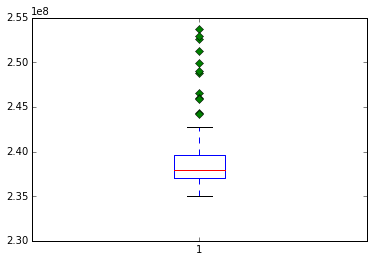

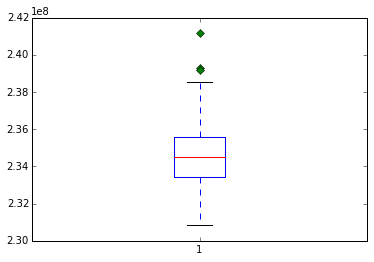

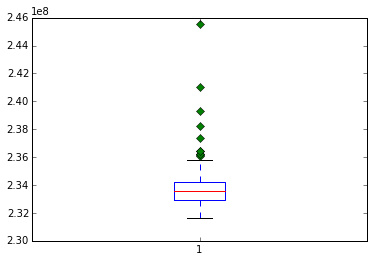

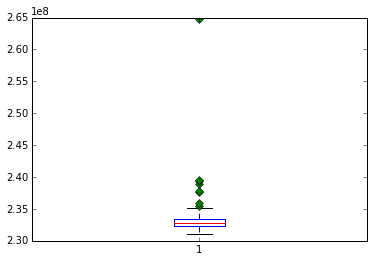

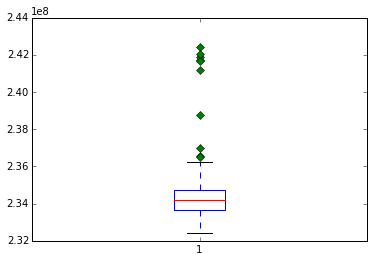

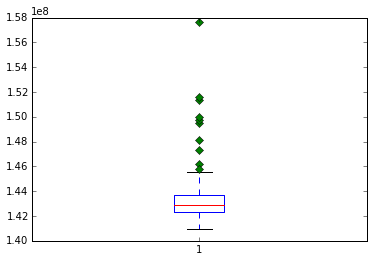

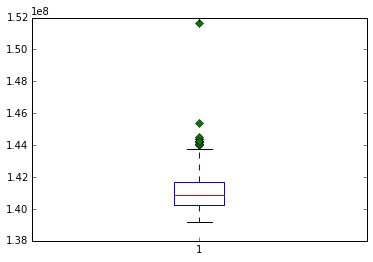

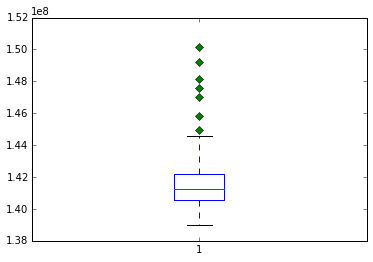

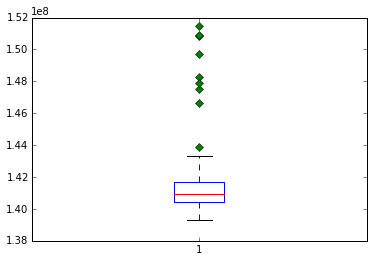

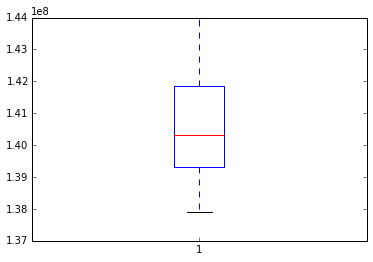

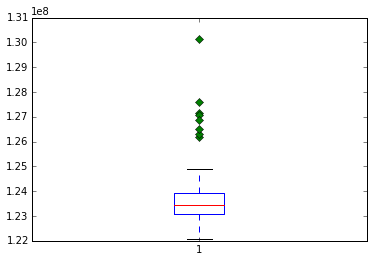

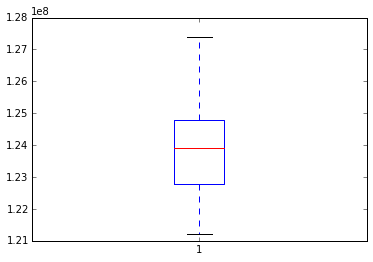

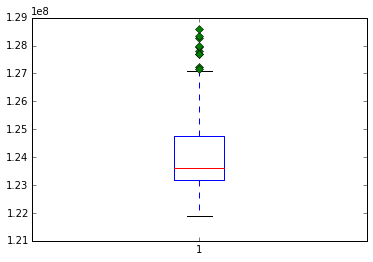

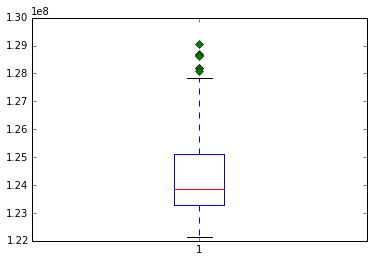

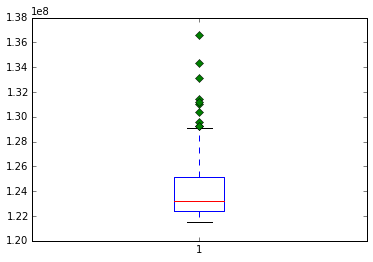

In [33]:
import ast
import pylab as pl

for x in ds['delta']:
    x = ast.literal_eval(x)
    pl.figure()
    pl.boxplot(x, 0,'gD')
    

In [92]:
import matplotlib.pyplot as plt

def plotLanguageComparison(filt, ds):
    dt = ds[ds['filter'] == filt][['language', 'size', 'tmean', 'min']]
    dt = dt.groupby('language')
    
    plt.ylabel('Clock Cycles')
    plt.xlabel('Size')
    
    for (label, group) in dt:
        del group['language']
        plt.plot(group['size'], group['min'], 'o', label=label)
    
    plt.legend(loc='upper left')

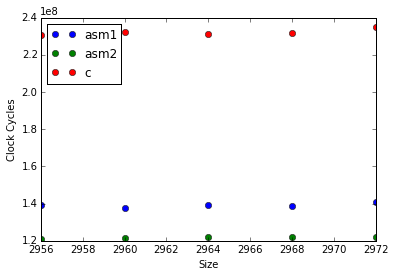

In [93]:
plotLanguageComparison('blur', ds)

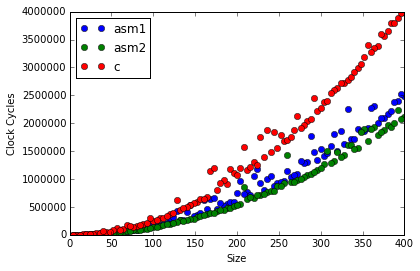

In [94]:
plotLanguageComparison('blur', data[(data['experiment'] == 'fixed-pixel-variable-size') & (data['make-param'] == 'o3fast')])

In [72]:
data['experiment'].value_counts()

fixed-pixel-variable-size          4500
random-pixel-fixed-size            4500
random-uniform-pixel-fixed-size    4500
hsl-force-last-if                   900
hsl-force-first-if                  900
dtype: int64

In [86]:
data[(data['experiment'] == 'fixed-pixel-variable-size') & (data['make-param'] == 'o3fast')]

,alpha,experiment,filename,filter,h,l,language,make-param,mean,min,s,size,tmean,var
13800,NaN,fixed-pixel-variable-size,fixed 320x320 (760313750),hsl,0,0,c,o3fast,16460631.04,15865439,0,320,15900013.22,1.342669e+13
13801,NaN,fixed-pixel-variable-size,fixed 320x320 (760313750),hsl,99,0,c,o3fast,11970785.89,9988384,0,320,10017366.78,4.824265e+13
13802,NaN,fixed-pixel-variable-size,fixed 188x188 (1734575198),hsl,0,0,c,o3fast,9982508.94,5474434,0,188,5563397.00,9.505386e+13
13803,NaN,fixed-pixel-variable-size,fixed 188x188 (1734575198),hsl,99,0,c,o3fast,5475365.29,3446711,0,188,3453110.68,8.854589e+13
13804,NaN,fixed-pixel-variable-size,fixed 88x88 (521595368),hsl,0,0,c,o3fast,1244912.62,1200325,0,88,1200558.12,9.197618e+10
13805,NaN,fixed-pixel-variable-size,fixed 88x88 (521595368),hsl,99,0,c,o3fast,760549.39,756146,0,88,756694.44,1.528530e+08
13806,NaN,fixed-pixel-variable-size,fixed 64x64 (1967513926),hsl,0,0,c,o3fast,646437.39,614859,0,64,635948.20,2.477883e+09
13807,NaN,fixed-pixel-variable-size,fixed 64x64 (1967513926),hsl,99,0,c,o3fast,417203.52,413844,0,64,414269.84,5.776834e+08
13808,NaN,fixed-pixel-variable-size,fixed 92x92 (294702567),hsl,0,0,c,o3fast,2666443.08,1357288,0,92,1401999.34,4.040657e+13
13809,NaN,fixed-pixel-variable-size,fixed 92x92 (294702567),hsl,99,0,c,o3fast,889514.84,855012,0,92,886484.00,1.036429e+09
